In [33]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree, ConvexHull

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

Using same values from Patel et al.

In [30]:
vsun = coord.CartesianDifferential([11.1, 251.24, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, galcen_v_sun=vsun)

In [22]:
g = GaiaData('../data/products/gaia-selected.fits')
# g = g[(g.dec < -29*u.deg) & (g.dec > -29.8*u.deg)]
g = g[g.G0 < 18.5]

In [124]:
_gal = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg).galactic
l = _gal.l
b = _gal.b

# vlsr = 25. * u.km/u.s
vlsr = 80. * u.km/u.s
vbsr = vlsr - (9*u.km/u.s * np.cos(l)*np.cos(b) + 
               12*u.km/u.s * np.sin(l)*np.cos(b) +
               7*u.km/u.s * np.sin(b))

In [125]:
c = g.get_skycoord(distance=30*u.kpc, radial_velocity=vbsr)

In [126]:
galcen = c.transform_to(gc_frame)

In [127]:
pot = gp.MilkyWayPotential()

cl_w0 = gd.PhaseSpacePosition(galcen.cartesian)
lmc_w0 = gd.PhaseSpacePosition(pos=[-1.1, -41.1, -27.9] * u.kpc,
                               vel=[-57., -226, 221] * u.km/u.s)

In [128]:
cl_orbit = pot.integrate_orbit(cl_w0, dt=-1, n_steps=300)
lmc_orbit = pot.integrate_orbit(lmc_w0, dt=-1, n_steps=300)
lmc_orbit_fut = pot.integrate_orbit(lmc_w0, dt=1, n_steps=300)

In [129]:
cyl = cl_orbit.represent_as(coord.CylindricalRepresentation)
lmc_cyl = lmc_w0.represent_as(coord.CylindricalRepresentation)
lmc_fut_cyl = lmc_orbit_fut.represent_as(coord.CylindricalRepresentation)

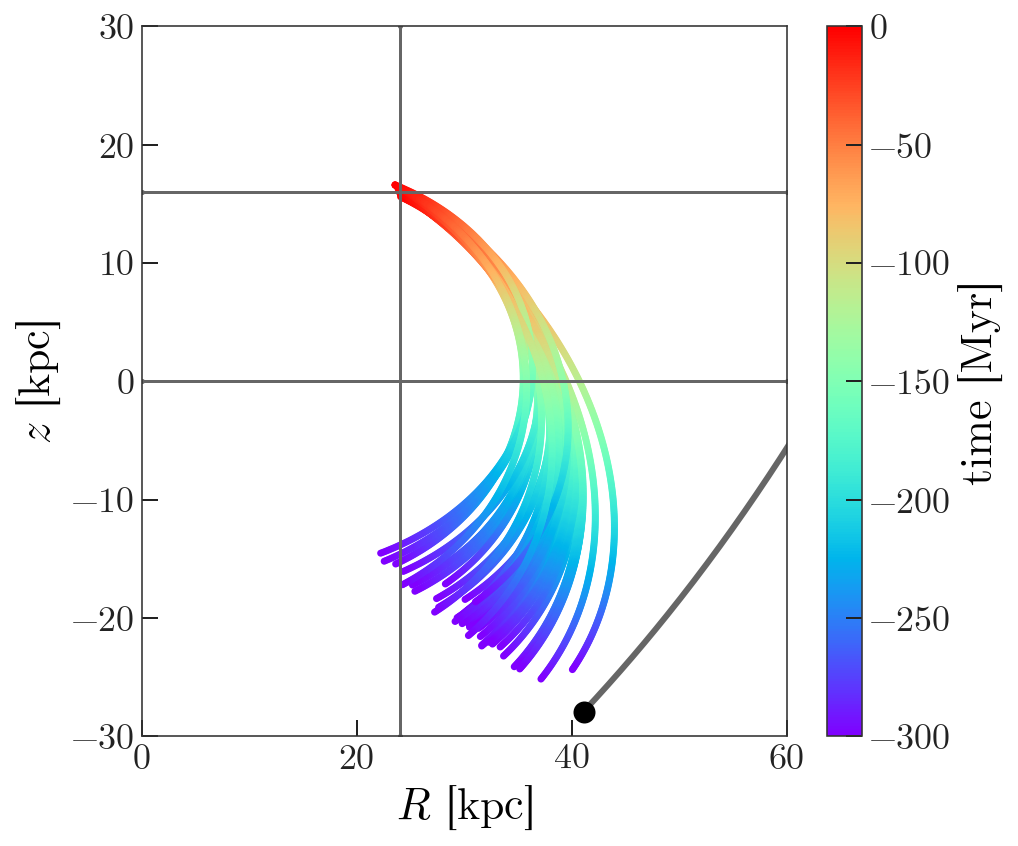

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 6))

for i in range(cyl.rho.shape[1]):
    _cs = ax.scatter(cyl.rho[:, i], cyl.z[:, i], 
                     c=cl_orbit.t.value, marker='.',
                     cmap='rainbow')

ax.scatter(lmc_cyl.rho, lmc_cyl.z, 
           marker='o', color='k', 
           s=100, zorder=100)
    
ax.plot(lmc_fut_cyl.rho, lmc_fut_cyl.z,
        ls='-', marker='', color='#666666', 
        zorder=-100, lw=3)
    
ax.set_xlim(0, 60)
ax.set_ylim(-30, 30)

ax.axhline(0)

ax.axvline(24)
ax.axhline(16)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

cb = fig.colorbar(_cs)
cb.set_label('time [Myr]')

fig.tight_layout()

(-200, 200)

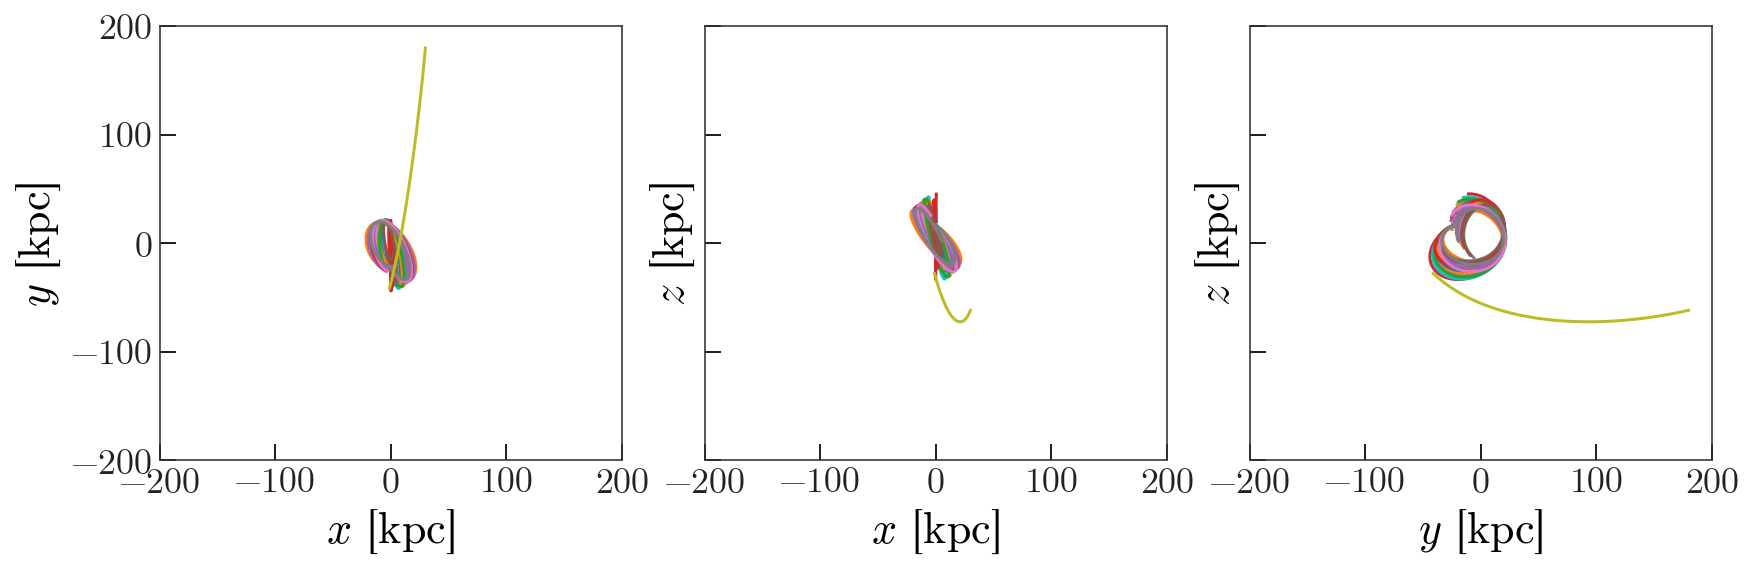

In [70]:
fig = cl_orbit.plot(auto_aspect=False, subplots_kwargs=dict(sharex=True, sharey=True))
_ = lmc_orbit.plot(auto_aspect=False, axes=fig.axes)

fig.axes[0].set_xlim(-200, 200)
fig.axes[0].set_ylim(-200, 200)

Compare longitude-distance to http://iopscience.iop.org/article/10.3847/1538-4357/835/2/285/meta Figure 16

In [140]:
cl_mag = cl_orbit.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)
lmc_mag = lmc_orbit_fut.to_coord_frame(gc.MagellanicStream, galactocentric_frame=gc_frame)

Text(0,0.5,'distance [kpc]')

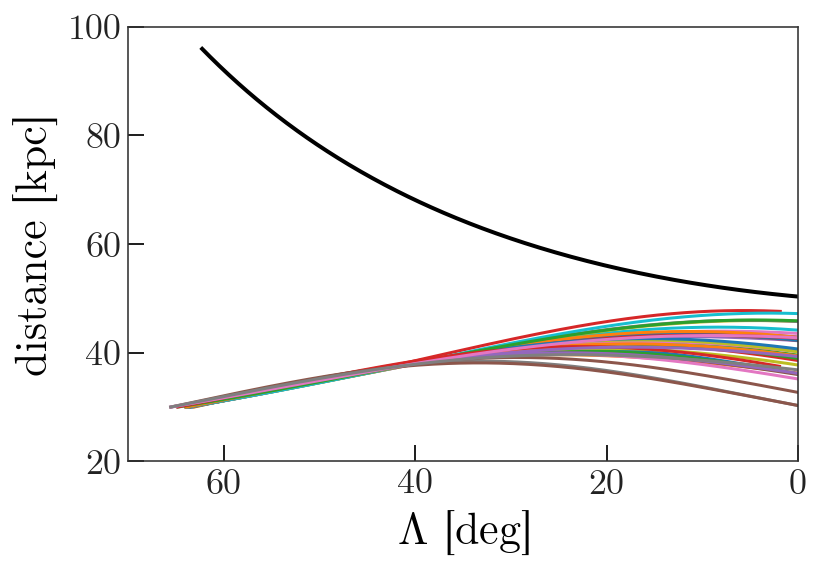

In [148]:
plt.plot(cl_mag.L.wrap_at(180*u.deg).degree,
         cl_mag.distance, marker='')

plt.plot(lmc_mag.L.wrap_at(180*u.deg).degree,
         lmc_mag.distance, 
         marker='', color='k', lw=2)

plt.xlim(70, 0)
plt.ylim(20, 100)
plt.xlabel(r'$\Lambda$ [deg]')
plt.ylabel(r'distance [kpc]')